In [1]:
import beanmachine.ppl as bm
import torch
import torch.nn as nn
import torch.distributions as dist
import torchvision.datasets
import torchvision.transforms as transforms
import torch.optim
import itertools
from beanmachine.ppl.world import World
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

Define a variational autoencoder with prior $z \overset{iid}{\sim} N(0,1)$, likelihood (i.e. "decoder" / reconstruction model)
$x \mid z \overset{iid}{\sim} \text{Bernoulli}(\text{logits}=\text{FFWNN}(z))$, and variational
approximation (i.e. "encoder" / recognition model) $q(z \mid x) = N(z \mid \text{loc}=\text{FFWNN}(z), \text{scale}=\text{FFWNN}(z))$.

In [3]:
m = 128  # minibatch size
d = 2  # dimension of encoded / latent RV z


@bm.random_variable
def z():
    return dist.Normal(
        loc=torch.zeros((m, d)).to(device),
        scale=torch.ones((m, d)).to(device),
    )


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.x_to_h = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
        )
        self.h_to_loc = nn.Linear(256, d).to(device)
        self.h_to_scale = nn.Sequential(
            nn.Linear(256, d),
            nn.Softplus(),
        )

    def forward(self, x):
        h = self.x_to_h(x)
        return dist.Normal(
            loc=self.h_to_loc(h),
            scale=self.h_to_scale(h)
        )


encoder = Encoder().to(device)


@bm.random_variable
def qz():
    return encoder(x())


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_to_logits = nn.Sequential(
            nn.Linear(d, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28)
        )

    def forward(self, z):
        logits = self.z_to_logits(z)
        return dist.Bernoulli(logits=logits)


decoder = Decoder().to(device)


@bm.random_variable
def x():
    return decoder(z())

Optimize the VAE by minimizing negative ELBO (Monte-Carlo approximated using a reparameterized sample from $q(z \mid x)$).

This is the code which would need to be automated inside a general guide-based VI implementation. Details to consider:

 * The KL_qp loss can be easily generalized to accomodate multiple latent site/guide pairs (e.g. `{z: qz}` below), but will require users associate (either via decorators or at inference time like in `edward`) the two before inference
 * The `encoder`/`decoder` `nn.Module`s hold the result of performing VI in their `nn.Parameter` state; both `edward` and `pyro` provide their own abstraction for `Parameter` which is used for (1) registration of the `Parameter` with the `Optimizer` and (2) association with optimized variational parameters / overriding with the optimized value. We will either need to provide a similar `bm.Param` construct to register these parameters and override them with VI return values, or alternatively we can allow users to provide abstractly `nn.Parameter`s for us to optimize (does not work for open-universe) and delegate concern about how these parameters are used in models (e.g. `encoder`/`decoder` above).

In [4]:
x_rvid = x()
qz_rvid = qz()
z_rvid = z()

mnist = torchvision.datasets.MNIST(
    '~/data', download=True,
    transform=transforms.ToTensor(),
)
mnist_loader = torch.utils.data.DataLoader(
    mnist, batch_size=m, shuffle=True,
)

optimizer = torch.optim.RMSprop(
    itertools.chain(
        encoder.parameters(),
        decoder.parameters(),
    ),
    lr=0.001, eps=1.0
)

for epoch in tqdm(range(1, 4), desc="epoch"):
    tqdm.write(f"Epoch: {epoch}")
    avg_loss = 0.0
    n = 0
    for X, _ in tqdm(iter(mnist_loader), desc="minibatch"):
        X = X.to(device)
        with World() as world:
            world.set_initialize_from_prior(True)
            try:
                world.set_observations({x_rvid: X.reshape(m, 28 * 28)})
            except RuntimeError:
                # skip very last minibatch, has < m samples
                continue
            for node in [x_rvid, z_rvid, qz_rvid]:
                world.call(node)
            world.accept_diff()

            # MC approximate ELBO expectation with sample z ~ q(z)
            qz_var = world.get_node_in_world_raise_error(qz_rvid)
            qz_sample = qz_var.distribution.rsample(sample_shape=z().shape)
            world.propose_change(qz_rvid, qz_sample)
            z_var = world.get_node_in_world_raise_error(z_rvid)
            world.propose_change(z_rvid, qz_sample)

            # negative ELBO, every {z: qz} pair should be included like this
            loss = qz_var.log_prob  # entropy
            loss -= z_var.log_prob  # prior
            loss -= sum([
                world.get_node_in_world_raise_error(z_child).log_prob
                for z_child in z_var.children
            ])  # likelihood
            loss /= m

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss
            n += x().shape[0]
            tqdm.write(f"log p(x) >= {-avg_loss/n:0.3e}", end='')

Epoch: 1


log p(x) >= -3.541e+02
Epoch: 2


log p(x) >= -3.815e+02
Epoch: 3


log p(x) >= -3.884e+02



Here is an example of taking an image from MNIST and computing its encoding distribution $q(z \mid x)$

In [19]:
X, _ = next(iter(mnist_loader))
q_x = encoder(X[0, ...].reshape(1, 28*28).cuda())
print(q_x.loc, q_x.scale)
transforms.ToPILImage()(X[0,...])

tensor([[-5.9621, -9.0735]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[1.1023e-06, 6.7494e-06]], device='cuda:0', grad_fn=<SoftplusBackward>)


Decoding the mean of $q(z \mid x)$ using the reconstruction model gives

In [20]:
z_x = q_x.loc
x_z_x = decoder(z_x).probs.float().reshape(28, 28)
transforms.ToPILImage()(x_z_x)

Since the latent dimension is $2$, we can visualize the latent space by showing how the reconstruction model's density looks like at a grid of latent points

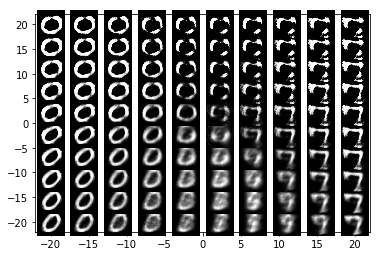

In [21]:
ax = plt.gca()

xmin, xmax, ymin, ymax = -20, 20, -20, 20
steps = 10

artists = []
for z1 in torch.linspace(xmin, xmax, steps=steps):
    for z2 in torch.linspace(ymin, ymax, steps=steps):
        x_z = (decoder(torch.tensor([z1, z2]).cuda()).probs).float().reshape((28,28))
        im = OffsetImage(transforms.ToPILImage()(x_z), zoom=1, cmap='gist_gray')
        ab = AnnotationBbox(im, (z1, z2), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
ax.set_xlim((xmin*1.1, xmax*1.1))
ax.set_ylim((ymin*1.1, ymax*1.1))
plt.show()